In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

from bbutils import BetaBernoulli, GenerativeModel

In [2]:
k = 10  # Number of classes

# Thetas from provider for each class
theta_provider = np.random.rand(k)
theta_provider[0] = 0.95

# True thetas of blackbox applied to our data. Class 0 has changed
theta_true = theta_provider.copy()
theta_true[0] = 0.90

In [3]:
# f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
# f.suptitle('Provider vs. True Accuracies')
# ax1.bar(range(k), theta_true)
# ax1.set_ylabel('True')
# ax2.bar(range(k), theta_provider)
# ax2.set_ylabel('Provider')
# ax3.bar(range(k), theta_true - theta_provider)
# ax3.set_ylabel('Difference')

In [4]:
n = 1_000
runs = 100

random_strategy_outcome = np.zeros((runs, n))
random_strategy_times_chosen = np.zeros((runs, n))

beta_bernoulli_outcome = np.zeros((runs, n))
beta_bernoulli_times_chosen = np.zeros((runs, n))


for r in range(runs):
    generative_model = GenerativeModel(theta_true)
    categories, observations = generative_model.sample(n)

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)

    # Random model

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        if category == 0:
            n_success += observation
            total += 1
        random_strategy_outcome[r, i] = (n_success + 1) / (total + 2 + 1e-13)
        random_strategy_times_chosen[r, i] = total

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # # Prior
    # alpha = np.round(theta_provider * 5)
    # beta = 5 - alpha
    # model._params = np.vstack((alpha + 1, beta + 1)).T

    n_success = 0
    total = 0
    for i in range(n):
        theta_hat = model.sample()
        diff = np.abs(theta_hat - theta_provider)
        choices = np.argsort(diff)[::-1]
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        if category == 0:
            n_success += observation
            total += 1
        #beta_bernoulli_outcome[i] = n_success / (total + 1e-13)
        beta_bernoulli_outcome[r, i] = model._params[0,0] / (model._params[0,0] + model._params[0,1])
        beta_bernoulli_times_chosen[r, i] = total
        model.update(category, observation)

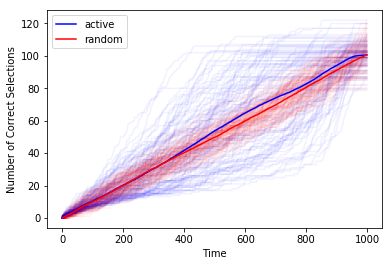

In [5]:
for i in range(runs):
    plt.plot(beta_bernoulli_times_chosen[i,:], c='blue', alpha=0.05)
    plt.plot(random_strategy_times_chosen[i,:], c='red', alpha=0.05)
plt.plot(np.mean(beta_bernoulli_times_chosen, axis=0), c='blue', label='active')
plt.plot(np.mean(random_strategy_times_chosen, axis=0), c='red', label='random')
plt.xlabel('Time')
plt.ylabel('Number of Correct Selections')
plt.legend()

In [6]:
# plt.plot(beta_bernoulli_outcome, c='blue', label='active')
# plt.plot(random_strategy_outcome, c='red', label='random')
# plt.xlabel('Time')
# plt.ylabel('MPE')
# plt.legend()

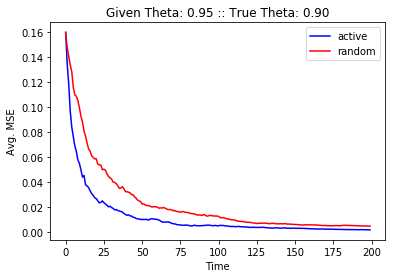

In [8]:
random_mse = (random_strategy_outcome - theta_true[0])**2
active_mse = (beta_bernoulli_outcome - theta_true[0])**2

plt.plot(np.mean(active_mse[:,:200], axis=0), c='blue', label='active')
plt.plot(np.mean(random_mse[:,:200], axis=0), c='red', label='random')
plt.title('Given Theta: 0.95 :: True Theta: 0.90')
plt.xlabel('Time')
plt.ylabel('Avg. MSE')
plt.legend()